In [135]:
import numpy as np
import cvxpy as cp

import plotly.graph_objects as go

In [168]:
## CVXPY MIQP example:

# Generate a random problem
np.random.seed(0)
m, n= 40, 25

A = np.random.rand(m, n)
b = np.random.randn(m)

# Construct a CVXPY problem
x = cp.Variable(n, integer=True)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
prob = cp.Problem(objective)
prob.solve()

print("Status: ", prob.status)
print("The optimal value is", prob.value)
print("A solution x is")
print(x.value)
print(f"Setup time: {prob.solver_stats.setup_time}, Solution time: {prob.solver_stats.solve_time}")

Status:  optimal
The optimal value is 13.660003251555075
A solution x is
[-1.  1.  1. -1.  0.  0. -1. -2.  0.  0.  0.  1.  1.  0.  1.  0. -1. -1.
 -1.  0.  2. -1.  2.  0. -1.]
Setup time: None, Solution time: None


Problem Formulation | Interger Constraints
- | - 
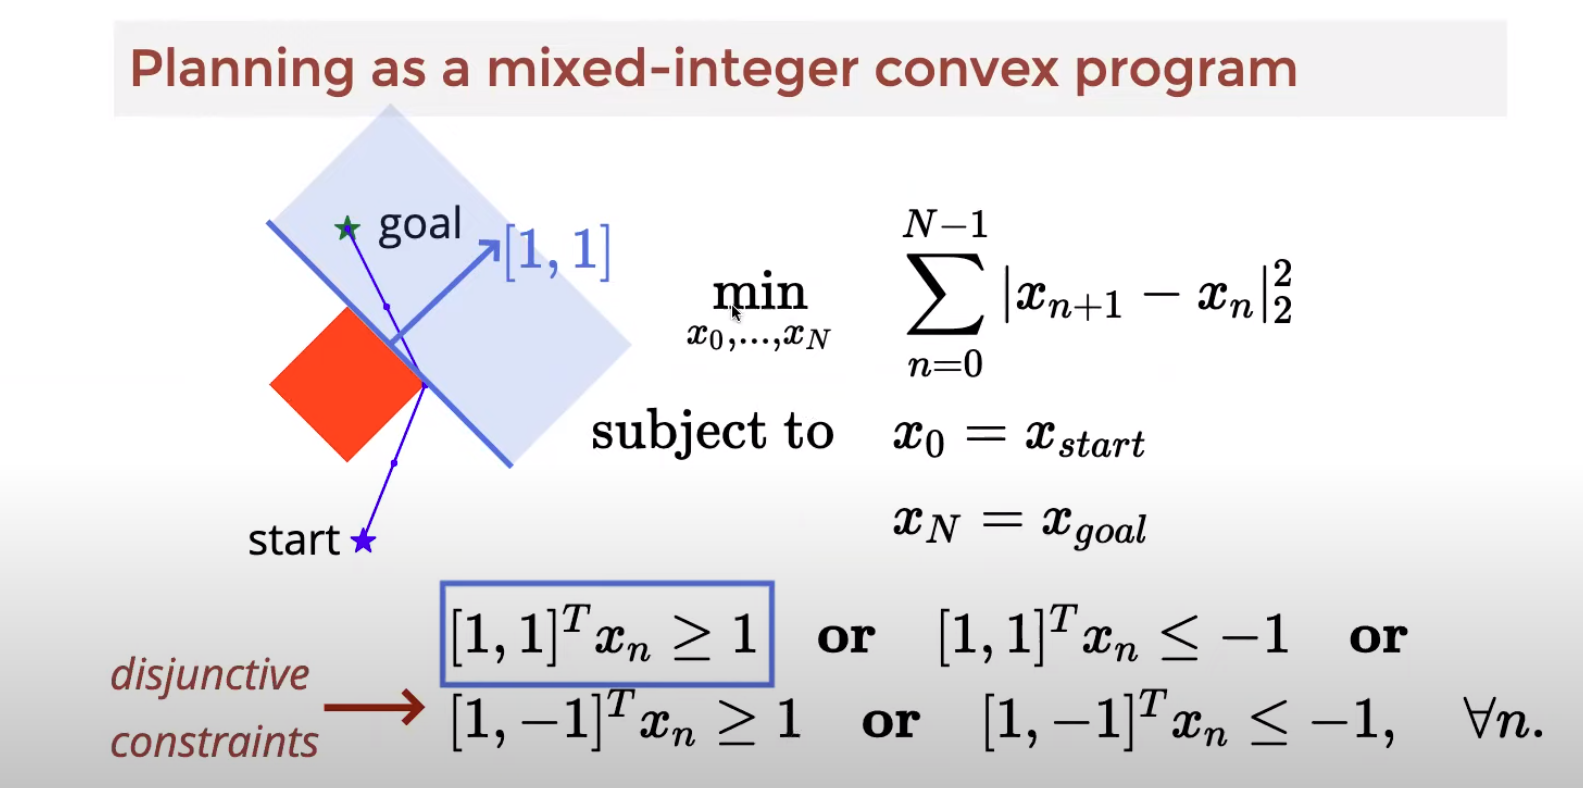 | 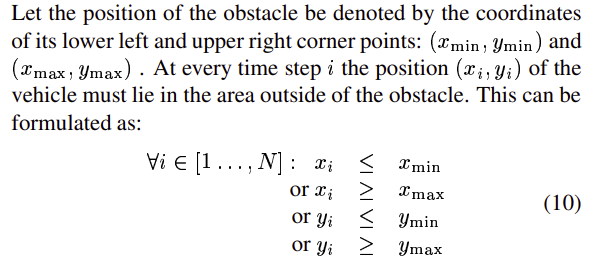 <br> 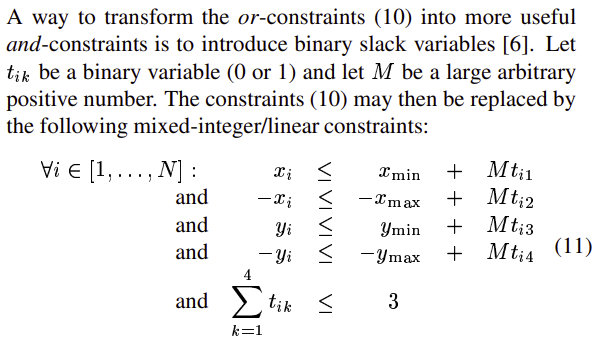


Status:  optimal
The optimal cost is 25.50000000001
A solution x is
[[ 0.   -0.25 -0.5  -0.25  0.  ]
 [-5.   -2.75 -0.5   2.25  5.  ]]
Optimal s:
[[ 1.  1.  1.  0.  1.]
 [ 1.  0.  0.  1.  1.]
 [-0.  0.  1.  1.  1.]
 [ 1.  1.  1.  0. -0.]]


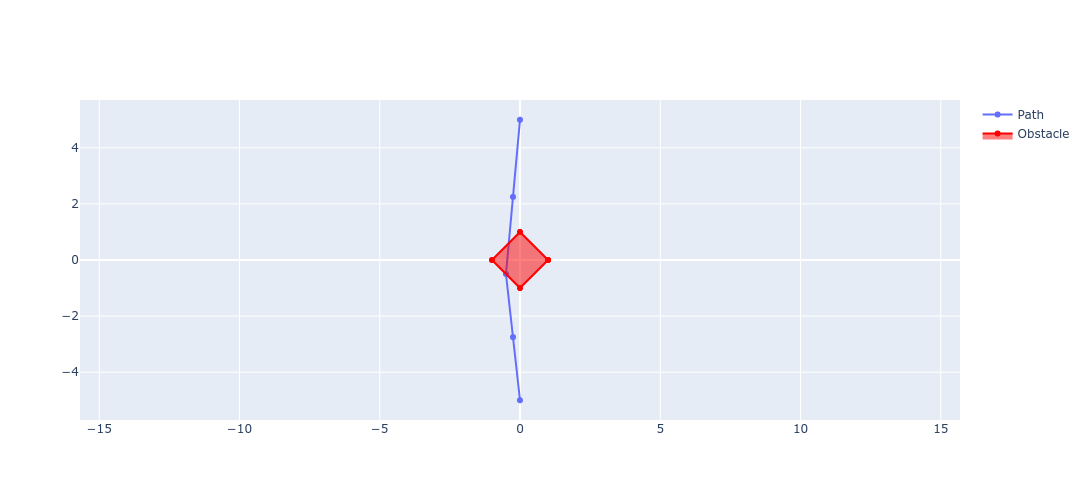

In [163]:
# L1 box obstacle example for single agent
# CVXPY MIQP example: https://www.cvxpy.org/examples/basic/mixed_integer_quadratic_program.html
# CVXPY trajectory optimization example: https://colab.research.google.com/github/cvxgrp/cvx_short_course/blob/master/intro/control.ipynb#scrollTo=fhczYBx97TRV

# Enter problem parameters here:
N = 5
k = 1
x_0 = [0, -5]
x_goal = [0, 5]

# For the agent to be outside of the box, one of these vectors dotted with the agent's position must be greater than one.
# cᵢ ⋅ xᵢ ≥ 1
# TODO: if you have multiple agents, do you just tile this matrix (repeat plane vectors for each agent), and then dot it with
# the whole state vector, or do you keep this the same and iterate through the agents upon constraint creation?
# TODO: I am a bit suspect of these constraints - the point [sqrt(2)/2, sqrt(2)/2] should be on the boundary of the box?
wall_plane_vectors = np.array([
    [1, 1],
    [-1, -1],
    [1, -1],
    [-1, 1],
])

# Define X vector: 1xn vector of position points in trajectory
x_dims = (2*k, N)
x = cp.Variable(x_dims)

# Define objective: sum of squared distance between points
cost = 0
for n in range(N - 1):
    # To find shortest path, minimize the distance between each steps
    cost += cp.sum_squares(x[:, n+1] - x[:, n])
objective = cp.Minimize(cost)

# Define intial and goal constraints
constr = []
constr += [x[:, 0] == x_0, x[:, N-1] == x_goal]

# Add obstacle constraints
M = 100000000
n_walls = len(wall_plane_vectors)
obs_dims = (n_walls, 1)
s = cp.Variable((n_walls, N), boolean=True)
ones_column = np.ones(obs_dims)
constr += [wall_plane_vectors @ x >= np.ones((n_walls, N)) - M*s, cp.sum(s, axis=0) <= len(wall_plane_vectors)-1]
                           
# Create and solve problem
scip_params={"numerics/feastol": 1e-12} # Need high accuracy of enforcing feasible sets for enforcing collision checking.

prob = cp.Problem(objective, constr)
prob.solve(solver="SCIP", scip_params=scip_params)

print("Status: ", prob.status)
print("The optimal cost is", prob.value)
print("A solution x is")
print(x.value)
print("Optimal s:")
print(s.value)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x.value[0, :],
    y=x.value[1, :],
    name="Path"
))

fig.add_trace(go.Scatter(
    x=[1, 0, -1, 0, 1],
    y=[0, 1, 0, -1, 0],
    fill="toself",
    name="Obstacle",
    line=dict(color="red")
))

fig.update_layout(yaxis_scaleanchor="x", width=600, height=500)
fig.show()

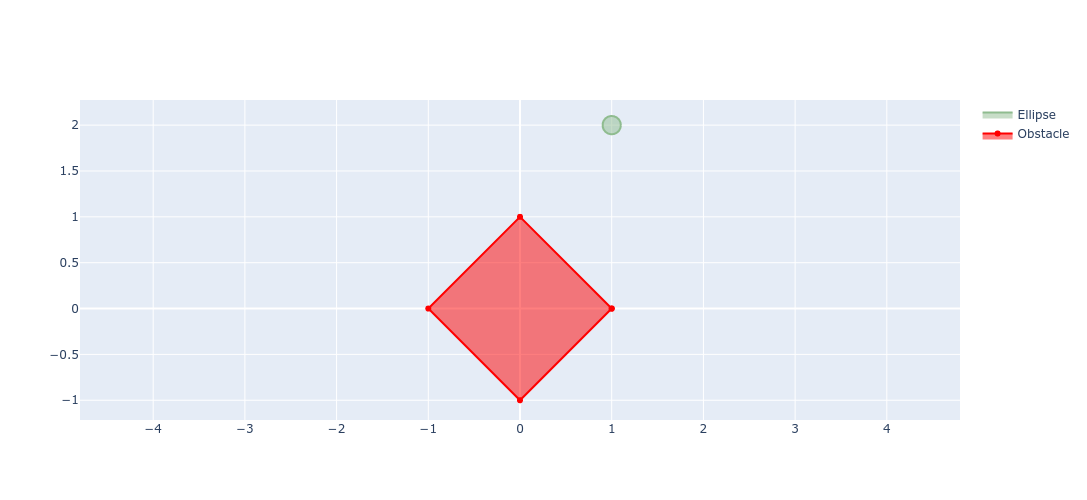

In [199]:
## Build a convex partitioning of the space with one square obstacle in it:
epsilon = 0.1
C_0 = np.eye(2) * epsilon
d_0 = np.array([[1, 2]]).T

obs = np.array([
    [1, 0],
    [0, 1],
    [-1, 0],
    [0, -1],
]).T

def plot_ellipse(C, d, fig = go.Figure()):
    s = np.linspace(0, 2*np.pi, 20)
    unit_circle_pts = np.array([np.cos(s), np.sin(s)])
    
    ellipse_pts = C @ unit_circle_pts + d
    fig.add_trace(go.Scatter(
        x=ellipse_pts[0, :],
        y=ellipse_pts[1, :],
        fill="toself",
        line=dict(color="darkseagreen"),
        name="Ellipse"
    ))

    fig.add_trace(go.Scatter(
        x=obs_vertices[0, :],
        y=obs_vertices[1, :],
        fill="toself",
        name="Obstacle",
        line=dict(color="red")
    ))

    fig.update_layout(yaxis_scaleanchor="x", width=600, height=500)
    return fig
    
fig = plot_ellipse(C_0, d_0)
fig.show()

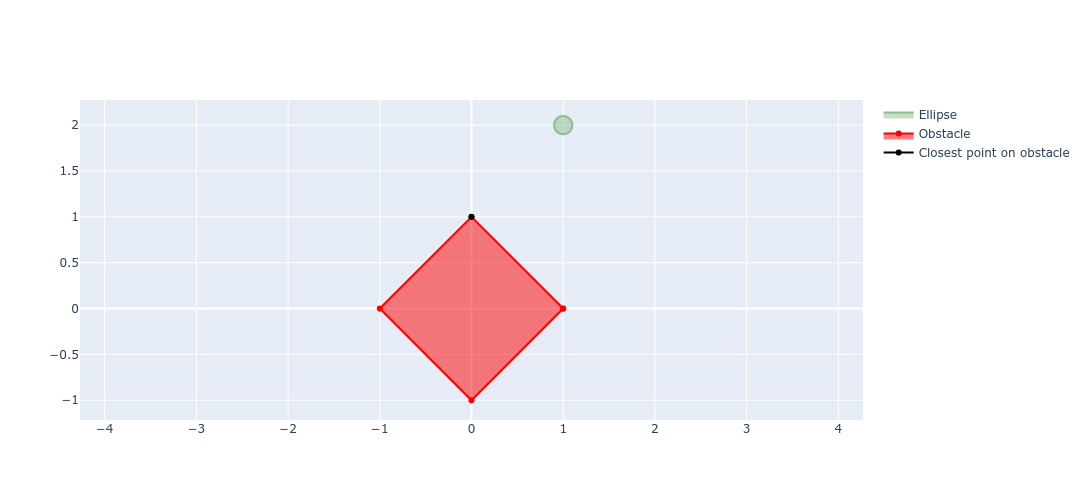

In [201]:
def find_hyperplanes(C, d, obs):
    # Step 1: Find separating hyperplanes which will allow further expansion of the ellipse:
    # Step 1a: Find the point on the obstacle closest to the ellipsoid
    # Transform obstacle points from world frame into world-space into ball-space
    obs_ball_space = np.linalg.inv(C) @ (obs - d)
    
    # For each obstacle, find the point on its boundary which is closest to the origin
    # by solving the quadratic program defined in Eqn.4 in Deits 2014
    # Note that x_tilde is in ball-space!
    x_tilde = cp.Variable((2, 1))
    wvar = cp.Variable((obs.shape[1], 1), nonneg=True)
    obj = cp.Minimize(cp.sum_squares(x_tilde)) # Find point which is closest to origin
    constr = [obs_ball_space @ wvar == x_tilde, cp.sum(wvar) == 1] # Constrain x to surface of obstacle via convex combination of vertices
    prob = cp.Problem(obj, constr)
    prob.solve()
    
    # Transform the closest point in ball-space back to world space
    x_star = C @ x_tilde.value + d

    # Step 1b: Find a and b defining the plane tangent to ellipse which passes through x_star
    
    

x_star = find_hyperplanes(C_0, d_0, obs)

fig = go.Figure()
plot_ellipse(C_0, d_0, fig)
fig.add_trace(go.Scatter(
    x=x_star[0],
    y=x_star[1],
    name="Closest point on obstacle",
    marker=dict(color="black")
))